# **Assignment#3**

Conducting a simple experiment for multi-classification using CIFAR-10 with MLP

*   Hyperparameter tuning
    - Find the combination of hyperparameters based on your own idea

1.   No. of hidden layers, No. of hidden units
2.   Learning rate
3.   Weight initialization depending on activation function
     - (Glorot) Xavier, (Kaiming) He
4.   Regularization
     - L2
     - Dropout

Note that you can report your final results to use other frameworks, such as Tensorflow, Theano, Julia, and etc.

# **Submitting your final results about "Accuracy" in terms of training, validation and Testing based on the optimal combination of hyperparameters you set up (by 11/04/24 23:59)**

 - The report should include codes and final results (figures)
----------------------------------------------------------------------------------

## Creating a directory "results"

In [1]:
!mkdir results

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy
import seaborn as sns
import matplotlib.pyplot as plt

# **Data Preparation**
- Use CIFAR10

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
partition = {'train': trainset, 'val':valset, 'test':testset}

100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# **Model Architecture**

In [26]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, n_layer, act, dropout, use_bn, w_initial):
        super(MLP, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act = act
        self.dropout = dropout
        self.use_bn = use_bn
        self.w_initial = w_initial

        # ====== Create Linear Layers ====== #
        self.fc1 = nn.Linear(self.in_dim, self.hid_dim)

        self.linears = nn.ModuleList()
        self.bns = nn.ModuleList()
        for i in range(self.n_layer-1):
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
            if self.use_bn:
                self.bns.append(nn.BatchNorm1d(self.hid_dim))

        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)

        # ====== Create Activation Function ====== #
        if self.act == 'relu':
            self.act = nn.ReLU()
        elif self.act == 'leakyrelu':
            self.act = nn.LeakyReLU()
        elif self.act == 'tanh':
            self.act = nn.Tanh()
        elif self.act == 'sigmoid':
            self.act = nn.Sigmoid()
        else:
            raise ValueError('no valid activation function selected!')

        # ====== Create Regularization Layer ======= #
        self.dropout = nn.Dropout(self.dropout)

        if self.w_initial == 'xavier':
            self.xavier_init()
        elif self.w_initial == 'he':
            self.he_init()
        else:
            raise ValueError("no valid initialization method selected!")

    def forward(self, x):
        x = self.act(self.fc1(x))
        for i in range(len(self.linears)):
            x = self.act(self.linears[i](x))
            if self.use_bn:
                x = self.bns[i](x)
            x = self.dropout(x)
        x = self.fc2(x)
        return x

    def xavier_init(self):
        for linear in self.linears:
            nn.init.xavier_normal_(linear.weight)
            linear.bias.data.fill_(0.01)

    def he_init(self):
        for linear in self.linears:
            nn.init.kaiming_normal_(linear.weight, nonlinearity='leaky_relu') # nonlinearity='leaky_relu' (default)
            linear.bias.data.fill_(0.01)


net = MLP(3072, 10, 100, 4, 'leakyrelu', 0.1, True, 'he') # in_dim, out_dim, hid_dim, n_layer, act, dropout, use_bn, w_initial
net

MLP(
  (fc1): Linear(in_features=3072, out_features=100, bias=True)
  (linears): ModuleList(
    (0-2): 3 x Linear(in_features=100, out_features=100, bias=True)
  )
  (bns): ModuleList(
    (0-2): 3 x BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (act): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.1, inplace=False)
)

# **train, validation, test and experiment**

In [5]:
def train(net, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(partition['train'],
                                              batch_size=args.train_batch_size,
                                              shuffle=True, num_workers=2)
    net.train()

    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        optimizer.zero_grad()
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 3072)
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

In [6]:
def validate(net, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'],
                                            batch_size=args.test_batch_size,
                                            shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images = images.view(-1, 3072)
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)

            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

In [7]:
def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'],
                                             batch_size=args.test_batch_size,
                                             shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.view(-1, 3072)
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc

In [8]:
def experiment(partition, args):
    # net = MLP(3072, 10, 100, 4, 'relu', 0.1, True, 'he') # in_dim, out_dim, hid_dim, n_layer, act, dropout, use_bn, w_initial
    net = MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act, args.dropout, args.use_bn, args.w_initial)
    net.cuda()

    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'ADAM':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(args.epoch):
        ts = time.time()
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(net, partition, criterion, args)
        te = time.time()

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))

    test_acc = test(net, partition, args)

    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result

# **Managing experimental results**



In [9]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']
    del setting['test_batch_size']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)


def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

# **Visualizing the result figures**

In [10]:
def plot_acc(var1, var2, df):

    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(15, 6)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    sns.barplot(x=var1, y='train_acc', hue=var2, data=df, ax=ax[0])
    sns.barplot(x=var1, y='val_acc', hue=var2, data=df, ax=ax[1])
    sns.barplot(x=var1, y='test_acc', hue=var2, data=df, ax=ax[2])

    ax[0].set_title('Train Accuracy')
    ax[1].set_title('Validation Accuracy')
    ax[2].set_title('Test Accuracy')


def plot_loss_variation(var1, var2, df, **kwargs):

    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_losses = list(row.train_losses)[0]
            val_losses = list(row.val_losses)[0]

            for epoch, train_loss in enumerate(train_losses):
                list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_loss in enumerate(val_losses):
                list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'loss', marker='.')
    g.add_legend()
    g.fig.suptitle('Train loss vs Val loss')
    plt.subplots_adjust(top=0.83) # Adjusting the value of top if the title and figure overlap each other


def plot_acc_variation(var1, var2, df, **kwargs):
    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_accs = list(row.train_accs)[0]
            val_accs = list(row.val_accs)[0]
            test_acc = list(row.test_acc)[0]

            for epoch, train_acc in enumerate(train_accs):
                list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_acc in enumerate(val_accs):
                list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

    def show_acc(x, y, metric, **kwargs):
        plt.scatter(x, y, alpha=0.3, s=1)
        metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
        plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
    g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

    g.add_legend()
    g.fig.suptitle('Train Accuracy vs Val Accuracy')
    plt.subplots_adjust(top=0.89)

# **Experiment No.1 : No. of hidden layers and hidden units**

In [43]:
from bayes_opt import BayesianOptimization

# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

parser = argparse.ArgumentParser()
args = parser.parse_args("")

# ====== Model Capacity ====== #
args.in_dim = 3072
args.out_dim = 10

cnt = 0

# ====== Experiment Variable ====== #
def exp_set(n_layer, hid_dim, act, dropout, use_bn, l2, w_initial, optim, lr, train_batch_size, test_batch_size):
    setattr(args, 'n_layer', int(n_layer))
    setattr(args, 'hid_dim', int(hid_dim))
    if act < 0.25:
        act = 'relu'
    elif act < 0.5:
        act = 'leakyrelu'
    elif act < 0.75:
        act = 'tanh'
    else:
        act = 'sigmoid'
    setattr(args, 'act', act)
    setattr(args, 'dropout', dropout)
    if use_bn < 0.5:
        use_bn = True
    else:
        use_bn = False
    setattr(args, 'use_bn', use_bn)
    setattr(args, 'l2', l2)
    if w_initial < 0.5:
        w_initial = 'he'
    else:
        w_initial = 'xavier'
    setattr(args, 'w_initial', w_initial)
    if optim < 1:
        optim = 'SGD'
    elif optim < 2:
        optim = 'RMSprop'
    else:
        optim = 'ADAM'
    setattr(args, 'optim', optim)
    setattr(args, 'lr', lr)
    setattr(args, 'epoch', 10)
    setattr(args, 'train_batch_size', int(train_batch_size))
    setattr(args, 'test_batch_size', int(test_batch_size))
    print(args)
    global cnt
    args.exp_name = f"exp{cnt}"
    cnt += 1

    setting, result = experiment(partition, deepcopy(args))
    save_exp_result(setting, result)
    return -1*result['val_losses'][-1]

optimizer = BayesianOptimization(
            f=exp_set,
            pbounds={
                    'n_layer': (1, 6),
                    'hid_dim': (100, 3000),
                    'act': (0,1),
                    'dropout': (0.0, 0.5),
                    'use_bn': (0,1),
                    'l2': (0.000001, 0.001),
                    'w_initial': (0,1),
                    'optim': (0,3),
                    'lr': (0.000001, 0.01),
                    'train_batch_size': (4, 256),
                    'test_batch_size': (4, 256)
                    },
            random_state=seed,
            verbose = 2
            )

optimizer.maximize(n_iter=100)

|   iter    |  target   |    act    |  dropout  |  hid_dim  |    l2     |    lr     |  n_layer  |   optim   | test_b... | train_... |  use_bn   | w_initial |
-------------------------------------------------------------------------------------------------------------------------------------------------------------
Namespace(in_dim=3072, out_dim=10, n_layer=3, hid_dim=757, act='tanh', dropout=np.float64(0.14306966747518973), use_bn=True, l2=np.float64(0.0005517634543138084), w_initial='he', optim='ADAM', lr=np.float64(0.007194970228885846), epoch=10, train_batch_size=125, test_batch_size=176)
Epoch 0, Acc(train/val): 24.28/29.99, Loss(train/val) 2.13/1.95. Took 7.88 sec
Epoch 1, Acc(train/val): 31.20/31.66, Loss(train/val) 1.90/1.89. Took 7.78 sec
Epoch 2, Acc(train/val): 32.94/32.50, Loss(train/val) 1.86/1.88. Took 7.20 sec
Epoch 3, Acc(train/val): 32.02/31.19, Loss(train/val) 1.88/1.90. Took 8.26 sec
Epoch 4, Acc(train/val): 32.16/32.03, Loss(train/val) 1.89/1.88. Took 8.38 sec
Epoch 

# **Visualizing the results**

In [64]:
import os

def load_all_results():
    dir_path = './results'
    filenames = [f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f)) and f.endswith('.json')]
    list_result = []
    for filename in filenames:
        with open(os.path.join(dir_path, filename), 'r') as infile:
            results = json.load(infile)
            list_result.append(results)
    df = pd.DataFrame(list_result)
    return df
df = load_all_results()
print(df['test_acc'].argmax())
df.iloc[93]

93


train_losses        [1.9066672624364074, 1.6550578886841634, 1.554...
val_losses          [1.694852121464618, 1.589529783694775, 1.51780...
train_accs          [31.445, 40.6875, 44.9575, 47.665, 50.095, 51....
val_accs            [39.22, 43.76, 46.25, 47.81, 48.85, 49.87, 50....
train_acc                                                       58.41
val_acc                                                         52.89
test_acc                                                        53.51
in_dim                                                           3072
out_dim                                                            10
n_layer                                                             4
hid_dim                                                           955
act                                                              relu
dropout                                                      0.268817
use_bn                                                          False
l2                  

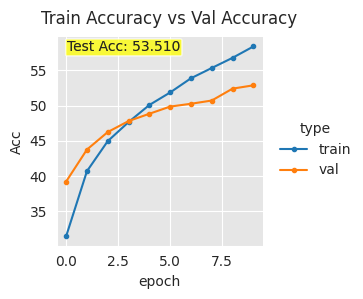

In [77]:
def plot_acc_(df, **kwargs):

    list_data = []


    train_accs = list(df.train_accs)[0]
    val_accs = list(df.val_accs)[0]
    test_acc = list(df.test_acc)[0]

    for epoch, train_acc in enumerate(train_accs):
        list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch})
    for epoch, val_acc in enumerate(val_accs):
        list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

    def show_acc(x, y, metric, **kwargs):
        plt.scatter(x, y, alpha=0.3, s=1)
        metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
        plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
    g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

    g.add_legend()
    g.fig.suptitle('Train Accuracy vs Val Accuracy')
    plt.subplots_adjust(top=0.89)
    
df = load_exp_result('exp30-4f85e0')
plot_acc_(df, margin_titles=True, sharey=True)